In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
from scipy.stats import pearsonr, spearmanr, ks_2samp, mannwhitneyu, ttest_ind

import sys
sys.path.append('../')

import utils
from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)

In [2]:
nlst_preds_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 122 entries, PatientID to Solid
dtypes: bool(25), float64(83), int64(11), object(3)
memory usage: 12.3+ MB


In [3]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

In [4]:
nlst_democols['num'].pop('nodule')

['CoordX', 'CoordY', 'CoordZ']

In [5]:
nlst_democols

{'num': {'demo': ['height', 'weight', 'Age', 'BMI'],
  'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr'],
  'other': ['NoduleCounts', 'Diameter [mm]']},
 'cat': {'demo': ['marital',
   'educat',
   'race',
   'ethnic',
   'Gender',
   'Married',
   'NonHispanicWhite',
   'HighSchoolPlus'],
  'smoke': ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework'],
  'work': ['wrkasbe',
   'wrkbaki',
   'wrkbutc',
   'wrkchem',
   'wrkcoal',
   'wrkcott',
   'wrkfarm',
   'wrkfire',
   'wrkflou',
   'wrkfoun',
   'wrkhard',
   'wrkpain',
   'wrksand',
   'wrkweld'],
  'disease': ['diagadas',
   'diagasbe',
   'diagbron',
   'diagchas',
   'diagchro',
   'diagcopd',
   'diagdiab',
   'diagemph',
   'diagfibr',
   'diaghear',
   'diaghype',
   'diagpneu',
   'diagsarc',
   'diagsili',
   'diagstro',
   'diagtube'],
  'canchist': ['cancblad',
   'cancbrea',
   'canccerv',
   'canccolo',
   'cancesop',
   'canckidn',
   'canclary',
   'canclung',
   'cancnasa',
   'cancoral',
   'cancpanc',
   'c

In [6]:
nlst_preds = utils.prep_nlst_preds(nlst_preds_nodule, scanlevel=True, tijmen=False, sybil=True)
nlst_preds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5911 entries, 0 to 10150
Columns: 117 entries, PatientID to Solid
dtypes: bool(25), float64(80), int64(11), object(1)
memory usage: 4.3+ MB


In [7]:
nlst_policy_thresholds = pd.read_csv(f"{NLST_PREDS}/policy-thresholds-{len(nlst_preds)}.csv", index_col=0)
nlst_policy_thresholds

,Sensitivity=0.9,Specificity=0.9,Youden J=1.0,Brock,col
Venkadesh,0.048,0.219,0.112,0.06,DL_cal
de Haas Combined,0.009,0.036,0.103,0.06,Thijmen_mean_cal
de Haas Local,0.045,0.212,0.144,0.06,Thijmen_local_cal
de Haas Global (hidden nodule),0.087,0.803,0.363,0.06,Thijmen_global_hidden
de Haas Global (w/nodule),0.068,0.300,0.131,0.06,Thijmen_global_show_cal
Sybil,0.003,0.057,0.017,0.06,sybil_year1
PanCan2b,0.015,0.165,0.035,0.06,PanCan2b


In [8]:
THRESHOLD = 'Brock'

In [9]:
sybil_worse_df = pd.read_csv(f"{NLST_PREDS}/sybil_worse.csv")
sybil_worse_df

,col,sym,val
0,wrknomask,=,True
1,FamilyHistoryLungCa,=,True
2,Emphysema,=,True
3,Gender,=,1
4,Married,=,True
5,wrkasbe,=,1
6,wrkfoun,=,1
7,diagadas,=,1
8,diagcopd,=,1
9,diagpneu,=,1


Sybil's worse columns are from our [scan level AUC results](./plot_nlst_scanlevel.ipynb).

PanCan columns from [Radiopaedia](https://radiopaedia.org/articles/brock-model-for-pulmonary-nodules).

The gender differential columns are from the "What about men vs women?" section of the [training info demographic splits notebook](./nlst/nlst_traininfo.ipynb).

In [10]:
pancan_cols = ['Age', 'Sex', 'FamilyHistoryLungCa', 'Emphysema', 'Diameter [mm]', 'NoduleInUpperLung', 'PartSolid', 'NoduleCounts', 'Spiculation']
train_diff_cols = ['pipe', 'cigar', 'Married', 'wrknomask', 'wrkfarm', 'smokework', 'diaghear', 'diagasbe', 'smokelive', 'diagpneu', 'diagchro', 'diagcopd', 'PersonalCancerHist', 'cigsmok', 'cancbrea', 'pkyr', 'smokeage']
relevant_cols = list(set(list(sybil_worse_df['col']) + pancan_cols + train_diff_cols + nlst_democols['cat']['lungcanc'] + nlst_democols['cat']['nodule']))

In [11]:
relevant_cols

['FamilyHistoryLungCa',
 'smokework',
 'smokelive',
 'Gender',
 'diagcopd',
 'PartSolid',
 'wrkfarm',
 'Bronchiolo-alveolar_carcinoma',
 'Married',
 'Age',
 'pipe',
 'height',
 'SemiSolid',
 'BMI',
 'NoduleCounts',
 'diagpneu',
 'smokeage',
 'Unclassified_carcinoma',
 'wrkfoun',
 'Small_cell_carcinoma',
 'wrknomask',
 'Carcinoid_tumor',
 'Emphysema',
 'Solid',
 'diagasbe',
 'pkyr',
 'NoduleInUpperLung',
 'weight',
 'Diameter [mm]',
 'Perifissural',
 'cigar',
 'cancbrea',
 'Calcified',
 'wrkasbe',
 'GroundGlassOpacity',
 'diagadas',
 'Adenosquamous_carcinoma',
 'Adenocarcinoma',
 'Large_cell_carcinoma',
 'NonSolid',
 'diagchro',
 'Squamous_cell_carcinoma',
 'Spiculation',
 'Sex',
 'PersonalCancerHist',
 'cigsmok',
 'diaghear']

In [12]:
nlst_preds[['sybil_year1']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5911 entries, 0 to 10150
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sybil_year1  5911 non-null   float64
dtypes: float64(1)
memory usage: 92.4 KB


In [13]:
MODEL_TO_COL = {
    "Venkadesh": "DL_cal",
    # "de Haas Combined": "Thijmen_mean_cal",
    "de Haas Local": "Thijmen_local_cal",
    "de Haas Global (hidden nodule)": "Thijmen_global_hidden",
    "de Haas Global (w/nodule)": "Thijmen_global_show_cal",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

In [14]:
nlst_preds['Sybil_pred_label'] = (nlst_preds[MODEL_TO_COL['Sybil']] > nlst_policy_thresholds.loc['Sybil', THRESHOLD]).astype(int).to_numpy()
nlst_preds['Sybil_PanCan_diff'] = nlst_preds[MODEL_TO_COL['Sybil']] - nlst_preds['PanCan2b']

In [15]:
false_positives = nlst_preds.query("label == 0 and Sybil_pred_label == 1")
false_negatives = nlst_preds.query("label == 1 and Sybil_pred_label == 0")

true_positives = nlst_preds.query("label == 1 and Sybil_pred_label == 1")
true_negatives = nlst_preds.query("label == 0 and Sybil_pred_label == 0")

## Difference between Training Info Splits

In [16]:
result_sets = {
    "FP": false_positives,
    "FN": false_negatives,
    "TP": true_positives,
    "TN": true_negatives, 
}

### utility code

In [17]:
def combine_col_dfs(cols=nlst_democols['cat'], df_func=pd.DataFrame, dfsets=result_sets, dispdf=False):
    splitdfs = []
    for cat in cols:
        if dispdf: display(Markdown(f"### {cat}"))
        
        for c in cols[cat]:
            df = df_func(c, dfsets)
            if dispdf: display(df)

            df['category'] = [cat] * len(df)
            df['attribute'] = [c] * len(df)
            df['value'] = df.index.values
            
            dfcols = df.columns.tolist()
            dfcols = dfcols[-3:] + dfcols[:-3]
            df = df[dfcols]
            df.reset_index(inplace=True, drop=True)
            df.sort_values(by='value', ascending=True, inplace=True)

            splitdfs.append(df)

    return pd.concat(splitdfs, axis=0, ignore_index=True)

In [18]:
def cat_dist_df(c='Gender', dfsets=result_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}_freq"] = dfsets[m][c].value_counts(normalize=False, dropna=False).astype(int)
        dfdict[f"{m}_norm"] = 100 * dfsets[m][c].value_counts(normalize=True, dropna=False).round(6)
        dfdict[f"{m}_freq"].fillna(0, inplace=True)
        dfdict[f"{m}_norm"].fillna(0, inplace=True)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                # dfdict[f"diff_freq_{m1}_{m2}"] = (dfdict[f"{m1}_freq"] - dfdict[f"{m2}_freq"]).round(4)
                dfdict[f"diff_norm_{m1}_{m2}"] = (dfdict[f"{m1}_norm"] - dfdict[f"{m2}_norm"]).round(4)
    
    df = pd.DataFrame(dfdict).drop_duplicates()

    for m in dfsets:
        df[f"{m}_freq"] = df[f"{m}_freq"].fillna(0.0)
        df[f"{m}_norm"] = df[f"{m}_norm"].fillna(0.0)

    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                # dfdict[f"diff_freq_{m1}_{m2}"] = (dfdict[f"{m1}_freq"] - dfdict[f"{m2}_freq"]).round(4)
                df[f"diff_norm_{m1}_{m2}"] = (df[f"{m1}_norm"] - df[f"{m2}_norm"]).round(4)    

    # df = pd.DataFrame(dfdict).drop_duplicates()
    return df

In [19]:
def num_dist_df(c='Gender', dfsets=result_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}"] = dfsets[m][c].describe(percentiles=[0.5]).round(4)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                dfdict[f"diff_{m1}_{m2}"] = dfdict[f"{m1}"] - dfdict[f"{m2}"]
    
    df = pd.DataFrame(dfdict).drop_duplicates()
    df.drop(index=['count', 'max', 'min', 'std'], inplace=True)
    return df

### differences

In [20]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, result_sets).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False)[cat_demo_splits['attribute'].isin(relevant_cols)])
cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True)[cat_demo_splits['attribute'].isin(relevant_cols)]

C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\1194108753.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False)[cat_demo_splits['attribute'].isin(relevant_cols)])


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,TP_freq,TP_norm,TN_freq,TN_norm,diff_norm_FP_FN,diff_norm_FP_TP,diff_norm_FP_TN,diff_norm_FN_TP,diff_norm_FN_TN,diff_norm_TP_TN
195,nodule,SemiSolid,1.0,168.0,32.8767,0.0,0.0000,0.0,0.0000,584.0,12.1187,32.8767,32.8767,20.7580,0.0000,-12.1187,-12.1187
187,nodule,GroundGlassOpacity,1.0,100.0,19.5695,0.0,0.0000,0.0,0.0000,1536.0,31.8738,19.5695,19.5695,-12.3043,0.0000,-31.8738,-31.8738
183,nodule,NoduleInUpperLung,1.0,360.0,70.4501,136.0,55.9671,212.0,62.7219,2353.0,48.8276,14.4830,7.7282,21.6225,-6.7548,7.1395,13.8943
25,demo,Gender,2.0,215.0,42.0744,84.0,34.5679,160.0,47.3373,2011.0,41.7306,7.5065,-5.2629,0.3438,-12.7694,-7.1627,5.6067
189,nodule,Perifissural,1.0,37.0,7.2407,0.0,0.0000,0.0,0.0000,487.0,10.1058,7.2407,7.2407,-2.8651,0.0000,-10.1058,-10.1058
65,work,wrkfarm,1.0,79.0,15.4599,22.0,9.0535,25.0,7.3964,587.0,12.1810,6.4064,8.0635,3.2789,1.6571,-3.1275,-4.7846
116,disease,diaghear,1.0,90.0,17.6125,31.0,12.7572,56.0,16.5680,625.0,12.9695,4.8553,1.0445,4.6430,-3.8108,-0.2123,3.5985
101,disease,diagchro,1.0,75.0,14.6771,26.0,10.6996,30.0,8.8757,488.0,10.1266,3.9775,5.8014,4.5505,1.8239,0.5730,-1.2509
122,disease,diagpneu,1.0,144.0,28.1800,62.0,25.5144,74.0,21.8935,1102.0,22.8678,2.6656,6.2865,5.3122,3.6209,2.6466,-0.9743
89,disease,diagadas,1.0,58.0,11.3503,22.0,9.0535,17.0,5.0296,278.0,5.7688,2.2968,6.3207,5.5815,4.0239,3.2847,-0.7392


C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\1194108753.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True)[cat_demo_splits['attribute'].isin(relevant_cols)]


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,TP_freq,TP_norm,TN_freq,TN_norm,diff_norm_FP_FN,diff_norm_FP_TP,diff_norm_FP_TN,diff_norm_FN_TP,diff_norm_FN_TN,diff_norm_TP_TN
211,lungcanc,Adenocarcinoma,1.0,0.0,0.0000,84.0,34.5679,149.0,44.0828,0.0,0.0000,-34.5679,-44.0828,0.0000,-9.5149,34.5679,44.0828
209,lungcanc,Squamous_cell_carcinoma,1.0,0.0,0.0000,60.0,24.6914,60.0,17.7515,0.0,0.0000,-24.6914,-17.7515,0.0000,6.9399,24.6914,17.7515
191,nodule,NonSolid,1.0,0.0,0.0000,39.0,16.0494,14.0,4.1420,0.0,0.0000,-16.0494,-4.1420,0.0000,11.9074,16.0494,4.1420
213,lungcanc,Bronchiolo-alveolar_carcinoma,1.0,0.0,0.0000,37.0,15.2263,61.0,18.0473,0.0,0.0000,-15.2263,-18.0473,0.0000,-2.8210,15.2263,18.0473
221,lungcanc,Unclassified_carcinoma,1.0,0.0,0.0000,32.0,13.1687,39.0,11.5385,0.0,0.0000,-13.1687,-11.5385,0.0000,1.6302,13.1687,11.5385
193,nodule,PartSolid,1.0,0.0,0.0000,25.0,10.2881,78.0,23.0769,0.0,0.0000,-10.2881,-23.0769,0.0000,-12.7888,10.2881,23.0769
38,smoke,pipe,1.0,99.0,19.3738,71.0,29.2181,72.0,21.3018,1059.0,21.9755,-9.8443,-1.9280,-2.6017,7.9163,7.2426,-0.6737
24,demo,Gender,1.0,296.0,57.9256,159.0,65.4321,178.0,52.6627,2808.0,58.2694,-7.5065,5.2629,-0.3438,12.7694,7.1627,-5.6067
185,nodule,Solid,1.0,357.0,69.8630,185.0,76.1317,252.0,74.5562,3206.0,66.5283,-6.2687,-4.6932,3.3347,1.5755,9.6034,8.0279
201,other,FamilyHistoryLungCa,1.0,130.0,25.4403,77.0,31.6872,103.0,30.4734,1217.0,25.2542,-6.2469,-5.0331,0.1861,1.2138,6.4330,5.2192


In [21]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, result_sets)
display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False)[num_demo_splits['attribute'].isin(relevant_cols)].head(20))
num_demo_splits.sort_values(by='diff_FP_FN', ascending=True)[num_demo_splits['attribute'].isin(relevant_cols)].head(20)

C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\2685756118.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False)[num_demo_splits['attribute'].isin(relevant_cols)].head(20))


,category,attribute,value,FP,FN,TP,TN,diff_FP_FN,diff_FP_TP,diff_FP_TN,diff_FN_TP,diff_FN_TN,diff_TP_TN
18,other,Diameter [mm],50%,12.5000,8.9000,14.6500,6.5000,3.6000,-2.1500,6.0000,-5.7500,2.4000,8.1500
19,other,Diameter [mm],mean,14.0337,11.3691,16.8672,7.8539,2.6646,-2.8335,6.1798,-5.4981,3.5152,9.0133
4,demo,Age,50%,64.0000,63.0000,64.0000,62.0000,1.0000,0.0000,2.0000,-1.0000,1.0000,2.0000
5,demo,Age,mean,64.1389,63.6008,64.3935,62.9768,0.5381,-0.2546,1.1621,-0.7927,0.6240,1.4167
11,smoke,smokeage,mean,16.4364,15.9877,16.3609,16.5333,0.4487,0.0755,-0.0969,-0.3732,-0.5456,-0.1724
17,other,NoduleCounts,mean,2.0020,1.9835,2.5059,1.8425,0.0185,-0.5039,0.1595,-0.5224,0.1410,0.6634
7,demo,BMI,mean,26.8548,26.8472,26.7522,27.7205,0.0076,0.1026,-0.8657,0.0950,-0.8733,-0.9683
10,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
16,other,NoduleCounts,50%,2.0000,2.0000,2.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000
6,demo,BMI,50%,26.3839,26.4488,25.9964,27.1219,-0.0649,0.3875,-0.7380,0.4524,-0.6731,-1.1255


C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\2685756118.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_demo_splits.sort_values(by='diff_FP_FN', ascending=True)[num_demo_splits['attribute'].isin(relevant_cols)].head(20)


,category,attribute,value,FP,FN,TP,TN,diff_FP_FN,diff_FP_TP,diff_FP_TN,diff_FN_TP,diff_FN_TN,diff_TP_TN
2,demo,weight,50%,172.0000,180.0000,170.0000,180.0000,-8.0000,2.0000,-8.0000,10.0000,0.0000,-10.0000
9,smoke,pkyr,mean,59.3614,63.5418,68.0504,57.2580,-4.1804,-8.6890,2.1034,-4.5086,6.2838,10.7924
8,smoke,pkyr,50%,51.2500,55.0000,57.0000,50.0000,-3.7500,-5.7500,1.2500,-2.0000,5.0000,7.0000
3,demo,weight,mean,176.9214,178.9050,174.7207,183.1018,-1.9836,2.2007,-6.1804,4.1843,-4.1968,-8.3811
0,demo,height,50%,68.0000,69.0000,68.0000,68.0000,-1.0000,0.0000,0.0000,1.0000,1.0000,0.0000
1,demo,height,mean,67.8549,68.2355,67.6024,68.0067,-0.3806,0.2525,-0.1518,0.6331,0.2288,-0.4043
6,demo,BMI,50%,26.3839,26.4488,25.9964,27.1219,-0.0649,0.3875,-0.7380,0.4524,-0.6731,-1.1255
10,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
16,other,NoduleCounts,50%,2.0000,2.0000,2.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000
7,demo,BMI,mean,26.8548,26.8472,26.7522,27.7205,0.0076,0.1026,-0.8657,0.0950,-0.8733,-0.9683


### Now with the top 100 scores that were different from PanCan

In [22]:
result_top_100_diff = {
    "FP": false_positives.sort_values(by=['Sybil_PanCan_diff'], ascending=False)[0:100],
    "FN": false_negatives.sort_values(by=['Sybil_PanCan_diff'], ascending=False)[0:100],
}

In [23]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, result_top_100_diff).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20))
cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20)

C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\3354373395.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20))


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,diff_norm_FP_FN
142,nodule,SemiSolid,1.0,21.0,21.0,0.0,0.0,21.0
134,nodule,GroundGlassOpacity,1.0,20.0,20.0,0.0,0.0,20.0
130,nodule,NoduleInUpperLung,1.0,62.0,62.0,45.0,45.0,17.0
136,nodule,Perifissural,1.0,10.0,10.0,0.0,0.0,10.0
67,disease,diagadas,1.0,17.0,17.0,9.0,9.0,8.0
78,disease,diagchro,1.0,14.0,14.0,6.0,6.0,8.0
53,work,wrkfarm,1.0,17.0,17.0,11.0,11.0,6.0
145,other,wrknomask,1.0,29.0,29.0,24.0,24.0,5.0
81,disease,diagcopd,1.0,9.0,9.0,5.0,5.0,4.0
92,disease,diaghear,1.0,15.0,15.0,13.0,13.0,2.0


C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\3354373395.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20)


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,diff_norm_FP_FN
157,lungcanc,Adenocarcinoma,1.0,0.0,0.0,46.0,46.0,-46.0
155,lungcanc,Squamous_cell_carcinoma,1.0,0.0,0.0,23.0,23.0,-23.0
34,smoke,pipe,1.0,15.0,15.0,28.0,28.0,-13.0
167,lungcanc,Unclassified_carcinoma,1.0,0.0,0.0,13.0,13.0,-13.0
138,nodule,NonSolid,1.0,0.0,0.0,12.0,12.0,-12.0
23,demo,Married,1.0,63.0,63.0,71.0,71.0,-8.0
159,lungcanc,Bronchiolo-alveolar_carcinoma,1.0,0.0,0.0,8.0,8.0,-8.0
132,nodule,Solid,1.0,78.0,78.0,85.0,85.0,-7.0
149,other,PersonalCancerHist,1.0,21.0,21.0,28.0,28.0,-7.0
32,smoke,cigsmok,1.0,48.0,48.0,54.0,54.0,-6.0


In [24]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, result_top_100_diff)
display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False)[num_demo_splits['attribute'].isin(relevant_cols)].head(20))
num_demo_splits.sort_values(by='diff_FP_FN', ascending=True)[num_demo_splits['attribute'].isin(relevant_cols)].head(20)

C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\900221855.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False)[num_demo_splits['attribute'].isin(relevant_cols)].head(20))


,category,attribute,value,FP,FN,diff_FP_FN
3,demo,weight,mean,181.1600,174.3400,6.8200
8,smoke,pkyr,50%,63.8750,57.1250,6.7500
19,other,Diameter [mm],mean,11.0110,6.4690,4.5420
18,other,Diameter [mm],50%,10.4000,6.1500,4.2500
7,demo,BMI,mean,26.9934,26.2540,0.7394
11,smoke,smokeage,mean,16.3400,15.7800,0.5600
1,demo,height,mean,68.5100,68.0700,0.4400
0,demo,height,50%,68.0000,68.0000,0.0000
16,other,NoduleCounts,50%,2.0000,2.0000,0.0000
10,smoke,smokeage,50%,16.0000,16.0000,0.0000


C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\900221855.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_demo_splits.sort_values(by='diff_FP_FN', ascending=True)[num_demo_splits['attribute'].isin(relevant_cols)].head(20)


,category,attribute,value,FP,FN,diff_FP_FN
4,demo,Age,50%,63.0000,64.0000,-1.0000
9,smoke,pkyr,mean,64.9935,65.6220,-0.6285
5,demo,Age,mean,63.2800,63.7900,-0.5100
2,demo,weight,50%,178.5000,179.0000,-0.5000
6,demo,BMI,50%,25.9846,26.4439,-0.4593
17,other,NoduleCounts,mean,2.0800,2.2000,-0.1200
10,smoke,smokeage,50%,16.0000,16.0000,0.0000
0,demo,height,50%,68.0000,68.0000,0.0000
16,other,NoduleCounts,50%,2.0000,2.0000,0.0000
1,demo,height,mean,68.5100,68.0700,0.4400


## False Positives

In [25]:
false_positives = nlst_preds.query("label == 0 and Sybil_pred_label == 1")
false_positives.sort_values(by=['Sybil_PanCan_diff'], ascending=False)[['SeriesInstanceUID', 'label', 'Sybil_pred_label', 'PanCan2b', 'sybil_year1', 'Sybil_PanCan_diff']]

,SeriesInstanceUID,label,Sybil_pred_label,PanCan2b,sybil_year1,Sybil_PanCan_diff
2263,1.2.840.113654.2.55.33732637722109895318342038...,0,1,0.029726,0.772670,0.742944
2265,1.2.840.113654.2.55.77963066942809127284230900...,0,1,0.021351,0.497134,0.475782
2264,1.2.840.113654.2.55.78096976623950740620273574...,0,1,0.025402,0.425152,0.399750
3985,1.3.6.1.4.1.14519.5.2.1.7009.9004.226754402382...,0,1,0.003607,0.401667,0.398060
929,1.2.840.113654.2.55.16240614331314545826126838...,0,1,0.004870,0.378627,0.373757
...,...,...,...,...,...,...
4598,1.3.6.1.4.1.14519.5.2.1.7009.9004.282429738608...,0,1,0.556694,0.168810,-0.387885
5279,1.2.840.113654.2.55.16023842072500469988489084...,0,1,0.539897,0.110097,-0.429800
4033,1.3.6.1.4.1.14519.5.2.1.7009.9004.188027548335...,0,1,0.669131,0.134700,-0.534431
7259,1.2.840.113654.2.55.98591848380988807922321793...,0,1,0.726740,0.190868,-0.535872


<Axes: xlabel='Sybil_PanCan_diff', ylabel='Count'>

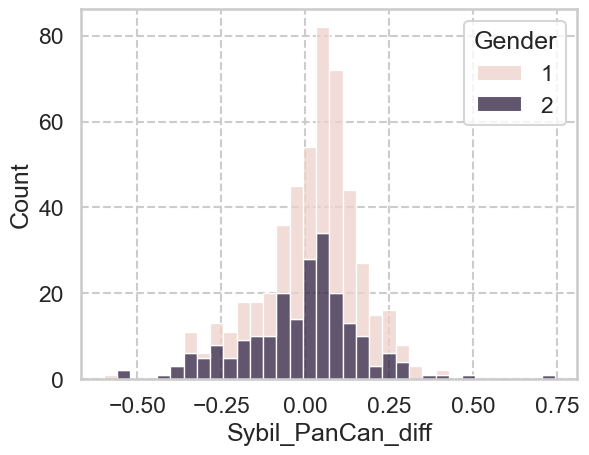

In [26]:
sns.histplot(false_positives, x='Sybil_PanCan_diff', hue='Gender', multiple='stack')

### Gender differences

In [27]:
gender_fps = {
    "M": false_positives.query("Gender == 1"),
    "F": false_positives.query("Gender == 2"),
}

In [28]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, gender_fps).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=False)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20))
cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=True)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20)

C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\43954872.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=False)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20))


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
23,demo,Gender,1.0,296.0,100.0000,0.0,0.0000,100.0000
32,smoke,cigar,1.0,93.0,31.4189,4.0,1.8605,29.5584
37,smoke,pipe,1.0,93.0,31.4189,6.0,2.7907,28.6282
156,other,wrknomask,1.0,111.0,37.5000,27.0,12.5581,24.9419
26,demo,Married,1.0,228.0,77.0270,119.0,55.3488,21.6782
58,work,wrkfarm,1.0,64.0,21.6216,15.0,6.9767,14.6449
99,disease,diaghear,1.0,66.0,22.2973,24.0,11.1628,11.1345
46,work,wrkasbe,1.0,29.0,9.7973,3.0,1.3953,8.4020
149,nodule,Perifissural,1.0,30.0,10.1351,7.0,3.2558,6.8793
35,smoke,cigsmok,1.0,146.0,49.3243,92.0,42.7907,6.5336


C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\43954872.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=True)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20)


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
24,demo,Gender,2.0,0.0,0.0000,215.0,100.0000,-100.0000
85,disease,diagchro,1.0,25.0,8.4459,50.0,23.2558,-14.8099
74,disease,diagadas,1.0,17.0,5.7432,41.0,19.0698,-13.3266
153,nodule,SemiSolid,1.0,85.0,28.7162,83.0,38.6047,-9.8885
160,other,PersonalCancerHist,1.0,75.0,25.3378,74.0,34.4186,-9.0808
104,disease,diagpneu,1.0,73.0,24.6622,71.0,33.0233,-8.3611
147,nodule,GroundGlassOpacity,1.0,49.0,16.5541,51.0,23.7209,-7.1668
88,disease,diagcopd,1.0,23.0,7.7703,32.0,14.8837,-7.1134
40,smoke,smokelive,1.0,255.0,86.1486,200.0,93.0233,-6.8747
158,other,FamilyHistoryLungCa,1.0,70.0,23.6486,60.0,27.9070,-4.2584


In [29]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, gender_fps)
display(num_demo_splits.sort_values(by='diff_M_F', ascending=False)[num_demo_splits['attribute'].isin(relevant_cols)].head(20))
num_demo_splits.sort_values(by='diff_M_F', ascending=True)[num_demo_splits['attribute'].isin(relevant_cols)].head(20)

C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\3018713410.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(num_demo_splits.sort_values(by='diff_M_F', ascending=False)[num_demo_splits['attribute'].isin(relevant_cols)].head(20))


,category,attribute,value,M,F,diff_M_F
2,demo,weight,50%,190.0000,148.0000,42.0000
3,demo,weight,mean,193.2102,154.4673,38.7429
9,smoke,pkyr,mean,64.2002,52.6998,11.5004
8,smoke,pkyr,50%,55.0000,47.0000,8.0000
1,demo,height,mean,70.6622,63.9720,6.6902
0,demo,height,50%,70.0000,64.0000,6.0000
6,demo,BMI,50%,26.7151,25.4014,1.3137
7,demo,BMI,mean,27.1426,26.4580,0.6846
19,other,Diameter [mm],mean,14.2828,13.6907,0.5921
18,other,Diameter [mm],50%,12.6500,12.3000,0.3500


C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\3018713410.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_demo_splits.sort_values(by='diff_M_F', ascending=True)[num_demo_splits['attribute'].isin(relevant_cols)].head(20)


,category,attribute,value,M,F,diff_M_F
4,demo,Age,50%,63.0000,64.0000,-1.0000
11,smoke,smokeage,mean,16.1486,16.8326,-0.6840
5,demo,Age,mean,63.9223,64.4372,-0.5149
16,other,NoduleCounts,50%,1.5000,2.0000,-0.5000
17,other,NoduleCounts,mean,1.9797,2.0326,-0.0529
10,smoke,smokeage,50%,16.0000,16.0000,0.0000
18,other,Diameter [mm],50%,12.6500,12.3000,0.3500
19,other,Diameter [mm],mean,14.2828,13.6907,0.5921
7,demo,BMI,mean,27.1426,26.4580,0.6846
6,demo,BMI,50%,26.7151,25.4014,1.3137


## False Negatives

In [30]:
false_negatives.sort_values(by=['Sybil_PanCan_diff'], ascending=True)[['SeriesInstanceUID', 'label', 'Sybil_pred_label', 'PanCan2b', 'sybil_year1', 'Sybil_PanCan_diff']]

,SeriesInstanceUID,label,Sybil_pred_label,PanCan2b,sybil_year1,Sybil_PanCan_diff
1464,1.2.840.113654.2.55.15839158435375720096247945...,1,0,0.724267,0.002192,-0.722076
4260,1.3.6.1.4.1.14519.5.2.1.7009.9004.298279943701...,1,0,0.670269,0.057416,-0.612852
3389,1.3.6.1.4.1.14519.5.2.1.7009.9004.184145865626...,1,0,0.518817,0.017994,-0.500824
262,1.2.840.113654.2.55.24192404935399215978590385...,1,0,0.461365,0.028122,-0.433243
2105,1.2.840.113654.2.55.14538535262458232659682438...,1,0,0.472720,0.054222,-0.418499
...,...,...,...,...,...,...
5321,1.2.840.113654.2.55.29479828645036951160762704...,1,0,0.028576,0.057416,0.028841
4635,1.3.6.1.4.1.14519.5.2.1.7009.9004.119783781701...,1,0,0.013267,0.043411,0.030143
1444,1.2.840.113654.2.55.89970394889282005802193271...,1,0,0.002880,0.033887,0.031006
19,1.2.840.113654.2.55.52511437849127555249917922...,1,0,0.011709,0.043411,0.031702


<Axes: xlabel='Sybil_PanCan_diff', ylabel='Count'>

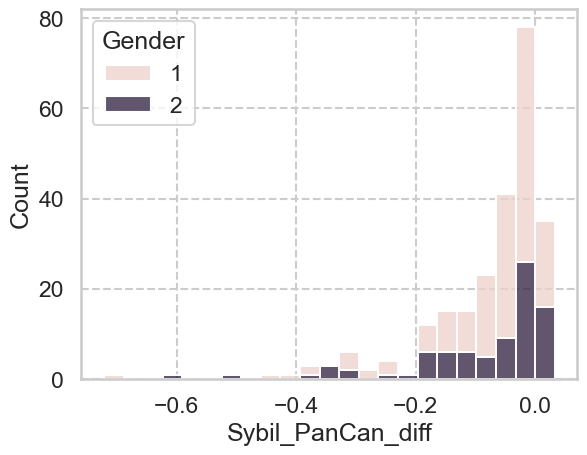

In [31]:
sns.histplot(false_negatives, x='Sybil_PanCan_diff', hue='Gender', multiple='stack')

In [32]:
gender_fns = {
    "M": false_negatives.query("Gender == 1"),
    "F": false_negatives.query("Gender == 2"),
}

In [33]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, gender_fns).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=False)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20))
cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=True)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20)

C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\1458553721.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=False)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20))


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
21,demo,Gender,1.0,159.0,100.0000,0.0,0.0000,100.0000
35,smoke,pipe,1.0,71.0,44.6541,0.0,0.0000,44.6541
30,smoke,cigar,1.0,56.0,35.2201,1.0,1.1905,34.0296
179,other,wrknomask,1.0,52.0,32.7044,16.0,19.0476,13.6568
24,demo,Married,1.0,120.0,75.4717,52.0,61.9048,13.5669
71,work,wrkfoun,1.0,20.0,12.5786,0.0,0.0000,12.5786
44,work,wrkasbe,1.0,21.0,13.2075,1.0,1.1905,12.0170
111,disease,diaghear,1.0,26.0,16.3522,5.0,5.9524,10.3998
189,lungcanc,Squamous_cell_carcinoma,1.0,44.0,27.6730,16.0,19.0476,8.6254
167,nodule,NoduleInUpperLung,1.0,93.0,58.4906,43.0,51.1905,7.3001


C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\1458553721.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=True)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20)


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
22,demo,Gender,2.0,0.0,0.0000,84.0,100.0000,-100.0000
33,smoke,cigsmok,1.0,73.0,45.9119,55.0,65.4762,-19.5643
183,other,PersonalCancerHist,1.0,47.0,29.5597,37.0,44.0476,-14.4879
117,disease,diagpneu,1.0,33.0,20.7547,29.0,34.5238,-13.7691
181,other,FamilyHistoryLungCa,1.0,45.0,28.3019,32.0,38.0952,-9.7933
85,disease,diagadas,1.0,10.0,6.2893,12.0,14.2857,-7.9964
191,lungcanc,Adenocarcinoma,1.0,51.0,32.0755,33.0,39.2857,-7.2102
133,canchist,cancbrea,1.0,0.0,0.0000,5.0,5.9524,-5.9524
118,disease,diagpneu,NaN,1.0,0.6289,5.0,5.9524,-5.3235
193,lungcanc,Bronchiolo-alveolar_carcinoma,1.0,22.0,13.8365,15.0,17.8571,-4.0206


In [34]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, gender_fns)
display(num_demo_splits.sort_values(by='diff_M_F', ascending=False)[num_demo_splits['attribute'].isin(relevant_cols)].head(20))
num_demo_splits.sort_values(by='diff_M_F', ascending=True)[num_demo_splits['attribute'].isin(relevant_cols)].head(20)

C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\3369854996.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(num_demo_splits.sort_values(by='diff_M_F', ascending=False)[num_demo_splits['attribute'].isin(relevant_cols)].head(20))


,category,attribute,value,M,F,diff_M_F
3,demo,weight,mean,193.0506,152.2976,40.7530
2,demo,weight,50%,185.0000,150.0000,35.0000
9,smoke,pkyr,mean,68.2632,54.6048,13.6584
8,smoke,pkyr,50%,61.5000,49.5000,12.0000
0,demo,height,50%,71.0000,64.0000,7.0000
1,demo,height,mean,70.3987,64.1667,6.2320
19,other,Diameter [mm],mean,12.2182,9.7619,2.4563
4,demo,Age,50%,64.0000,62.5000,1.5000
7,demo,BMI,mean,27.3643,25.8747,1.4896
18,other,Diameter [mm],50%,9.7000,8.3000,1.4000


C:\Users\shaur\AppData\Local\Temp\ipykernel_25528\3369854996.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_demo_splits.sort_values(by='diff_M_F', ascending=True)[num_demo_splits['attribute'].isin(relevant_cols)].head(20)


,category,attribute,value,M,F,diff_M_F
11,smoke,smokeage,mean,15.5723,16.7738,-1.2015
17,other,NoduleCounts,mean,1.8679,2.2024,-0.3345
10,smoke,smokeage,50%,16.0000,16.0000,0.0000
16,other,NoduleCounts,50%,2.0000,2.0000,0.0000
5,demo,Age,mean,63.7296,63.3571,0.3725
6,demo,BMI,50%,26.5784,25.3377,1.2407
18,other,Diameter [mm],50%,9.7000,8.3000,1.4000
7,demo,BMI,mean,27.3643,25.8747,1.4896
4,demo,Age,50%,64.0000,62.5000,1.5000
19,other,Diameter [mm],mean,12.2182,9.7619,2.4563
